In [1]:
#import library
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sds

In [2]:
#menyiapkan dataset

class PlanarDataset(object):
    def __init__(self, points_per_class):
        self.N = points_per_class

    def load_dataset(self, shape):
        X, Y = getattr(self, "get_"+shape)()
        X, Y = X.T, np.expand_dims(Y, 0)
        return X, Y
        
    def get_circles(self):
        return sds.make_circles(n_samples=self.N, factor=.5, noise=.3)

    def get_moons(self):      
        return sds.make_moons(n_samples=self.N, noise=.2)

    def get_blobs(self):
        X, Y = sds.make_blobs(n_samples=self.N, random_state=5, n_features=2, centers=6)
        Y = Y%2
        return X, Y

    def get_quantiles(self):
        return sds.make_gaussian_quantiles(mean=None, cov=0.5, 
                                           n_samples=self.N, n_features=2, 
                                           n_classes=2, shuffle=True, 
                                           random_state=1)      

    def get_random(self):
        return np.random.rand(self.N, 2), np.random.randint(2, size=self.N)

    def get_plain(self):
        X, Y = sds.make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                       n_informative=2, random_state=1, 
                                       n_clusters_per_class=1)
        rng = np.random.RandomState(2)
        X += 2 * rng.uniform(size=X.shape)
        return X, Y

    def get_flower(self):
        m = int(self.N / 2.)
        X = np.zeros((self.N,2)) 
        Y = np.zeros(self.N, dtype='uint8')
        a = 4 

        for j in range(2):
            ix = range(m*j, m*(j+1))
            t = np.linspace(j*3.12, (j+1)*3.12, m) + np.random.randn(m)*0.2 # theta
            r = a * np.sin(4*t) + np.random.randn(m)*0.2 # radius
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[ix] = j

        return X, Y

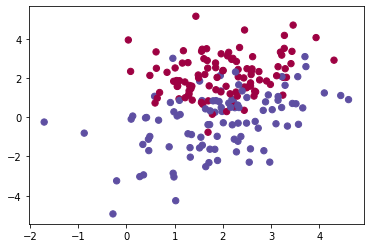

In [3]:
loader = PlanarDataset(200)

# Silakan coba-coba ganti parameternya
X, Y = loader.load_dataset('plain')
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [4]:
#fungsi pendukung

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

In [5]:
#model neural network dangkal

def initialize_parameters(n_x, n_h, n_y):    
    # inisialisasi W secara acak dan b dengan 0
    w1 = np.random.randn(n_x,n_h)
    b1 = np.zeros([n_h,1])
    w2 = np.random.randn(n_h,n_y)
    b2 = np.zeros([n_y,1])
    
    return w1, w2, b1, b2

#forward propagation
def forward_propagation(X, w1, w2, b1, b2):
    Z1 = np.dot(w1.T,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(w2.T,A1) + b2
    A2 = sigmoid(Z2)
        
    return A1, A2

#backward propagation
def backward_propagation(A1, A2, w2, X, Y):
    m = X.shape[1]

    dZ2 = ((-2*(Y-A2))/m)*A2*(1-A2) #dsigmoid
    dw2 = np.dot(A1,dZ2.T)
    
    db2 = np.sum(dZ2)
    dZ1 = np.dot(w2,dZ2)*(1-A1**2)  #dtanh
    dw1 = np.dot(X,dZ1.T)
    
    db1 = np.sum(dZ1)
    
    return dw1, dw2, db1, db2

#optimasi
def update_parameters(parameters, grads, learning_rate = 1.2):
    w1, w2, b1, b2 = parameters
    dw1, dw2, db1, db2 = grads

    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
        
    return w1, w2, b1, b2

#fungsi pelengkap
def compute_cost(A2, Y):
    m = Y.shape[1] # number of example

    cost = np.dot((Y-A2),(Y-A2).T)/m
    return float(np.squeeze(cost))

def predict(parameters, X):
    w1, w2, b1, b2 = parameters
    A1, A2 = forward_propagation(X,w1,w2,b1,b2)
    predictions = A2
    return predictions


def get_accuracy(parameters, X, Y):
    predictions = predict(parameters, X)
    correctly_predicted = np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T)
    accuracy = float(correctly_predicted)/float(Y.size)*100  
    print("train accuracy: {} %".format(accuracy))

In [6]:
#Final function
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 1.2, print_cost=False):    
    n_x = X.shape[0]
    n_y = Y.shape[0]
    #X = X.T
    #Y = Y.reshape((Y.shape[1], Y.shape[0]))
    parameters = initialize_parameters(n_x, n_h, n_y)
    w1, w2, b1 , b2 = parameters
    for i in range(0, num_iterations):
        A1, A2 = forward_propagation(X, w1, w2, b1, b2)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(A1,A2, w2, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % (num_iterations // 10) == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [7]:
#banyaknya neuron
hidden_neuron = 4

In [8]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, hidden_neuron, 100000, 0.5, True)
get_accuracy(parameters, X, Y)

Cost after iteration 0: 0.312255
Cost after iteration 10000: 0.097138
Cost after iteration 20000: 0.095772
Cost after iteration 30000: 0.094507
Cost after iteration 40000: 0.093462
Cost after iteration 50000: 0.092746
Cost after iteration 60000: 0.092194
Cost after iteration 70000: 0.091408
Cost after iteration 80000: 0.090945
Cost after iteration 90000: 0.090604
train accuracy: 82.51160861631053 %


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

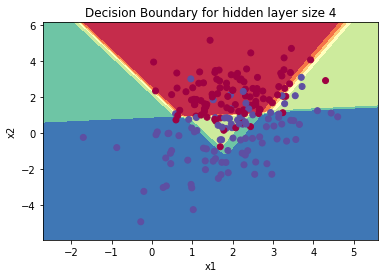

In [9]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(hidden_neuron))

Cost after iteration 0: 0.588782
Cost after iteration 10000: 0.099535
Cost after iteration 20000: 0.098729
Cost after iteration 30000: 0.098361
Cost after iteration 40000: 0.098123
Cost after iteration 50000: 0.097933
Cost after iteration 60000: 0.097766
Cost after iteration 70000: 0.097614
Cost after iteration 80000: 0.097472
Cost after iteration 90000: 0.097333
train accuracy: 80.24338902521549 %


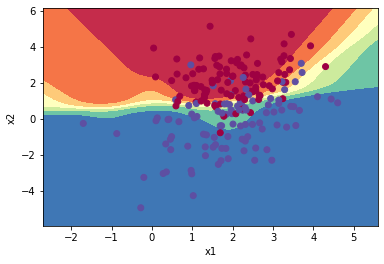

In [10]:
parameters = nn_model(X, Y, 8, 100000, 0.05, True)
get_accuracy(parameters, X, Y)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

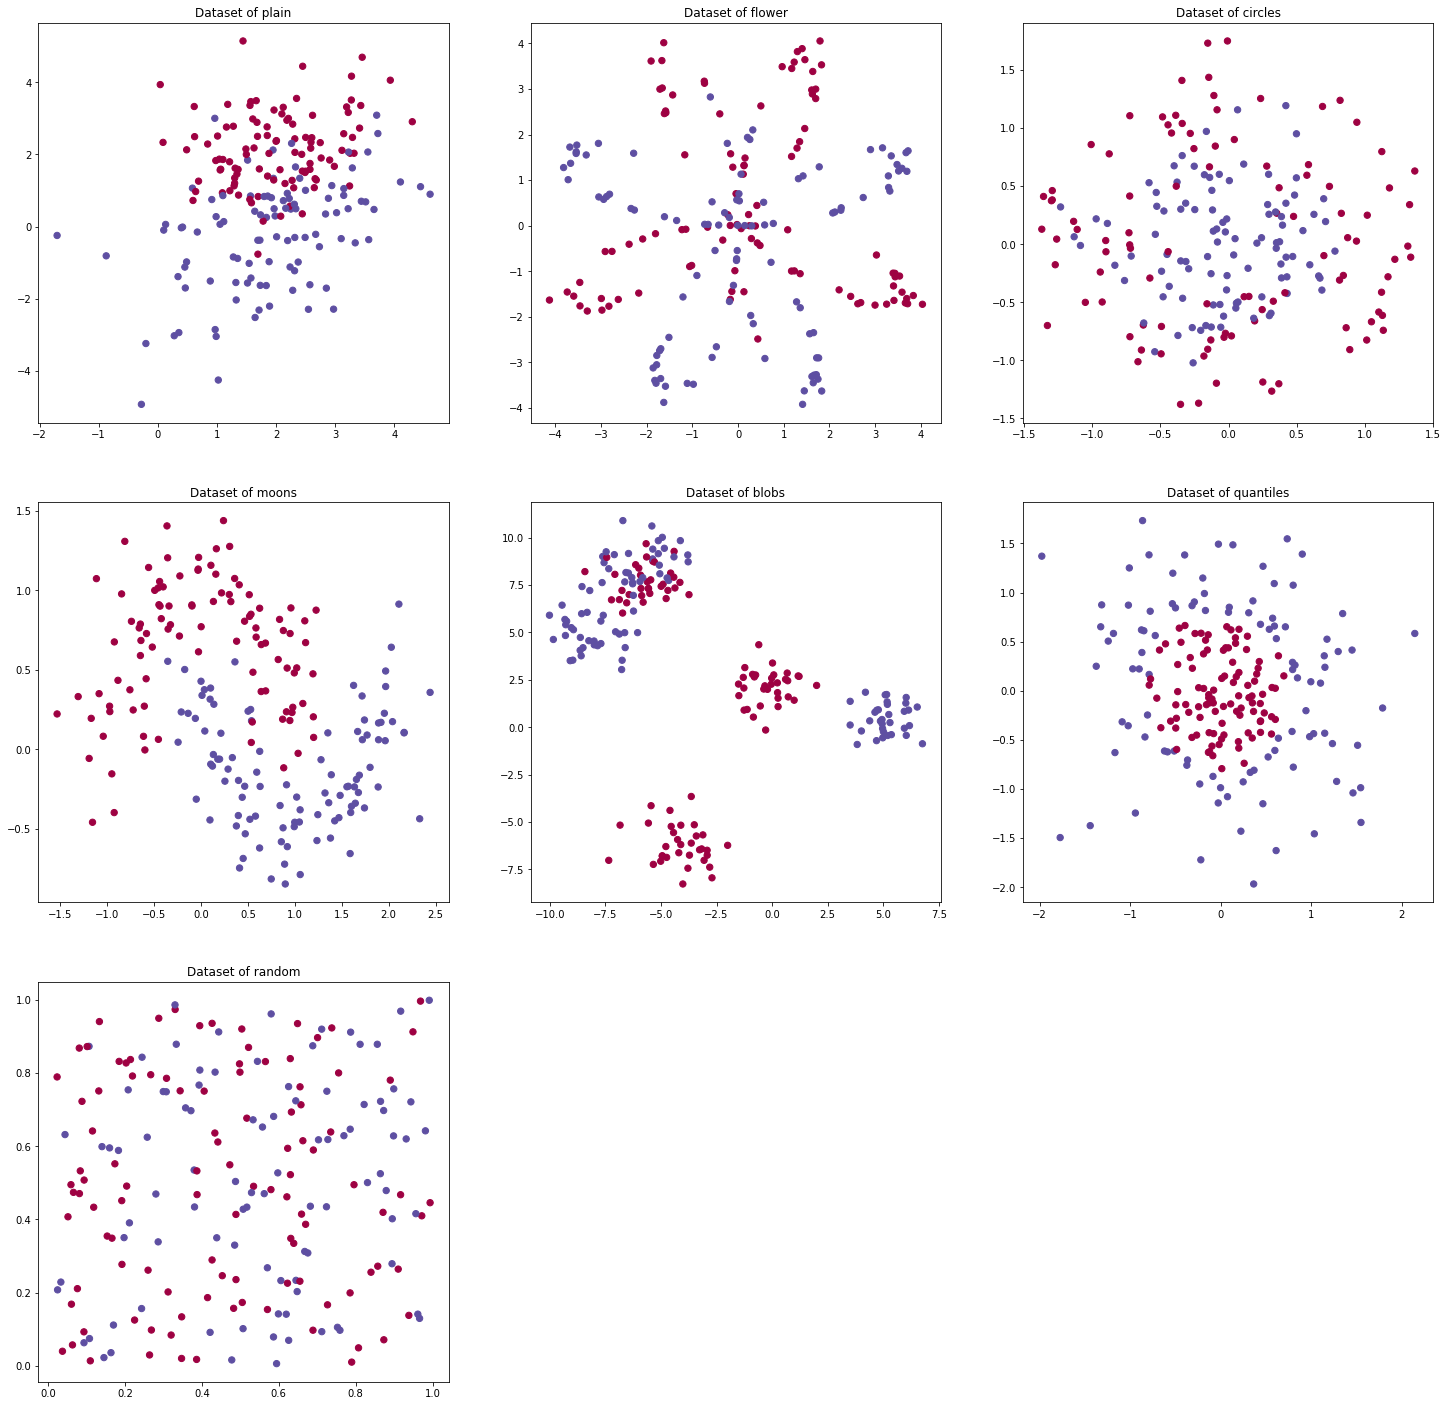

In [11]:
dataset_lst = [
    'plain', #0
    'flower', #1
    'circles', #2
    'moons', #3
    'blobs', #4
    'quantiles', #5 
    'random' #6
]
plt.figure(figsize=(25, 25))
for i, shape in enumerate(dataset_lst):
    plt.subplot(3, 3, i+1)
    plt.title("Dataset of "+shape)
    X, Y = loader.load_dataset(shape)  
    plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

# Dataset Flower

Pada dataset ini, kita dapat melihat bahwa akurasi meningkat secara signifikan ketika jumlah neuron pada jumlah neuron sama dengan 6 ke atas, ini dikarenakan jumlah neuron hanya 1 itu tidak ada bedanya dengan regresi logistik biasa. Tetapi 6 neuron juga merupakan titik optimalnya dikarenakan model dengan jumlah neuron yang lebih banyak tidak memiliki akurasi yang lebih bagus daripada 6 neuron.

Cost after iteration 0: 0.290765
Cost after iteration 10000: 0.083727
Cost after iteration 20000: 0.080226
Cost after iteration 30000: 0.078867
Cost after iteration 40000: 0.078030
Cost after iteration 50000: 0.077381
Cost after iteration 60000: 0.076811
Cost after iteration 70000: 0.076259
Cost after iteration 80000: 0.075660
Cost after iteration 90000: 0.074904
train accuracy: 84.0384447447065 %


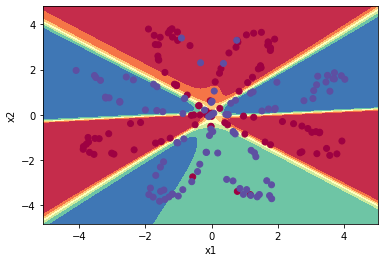

In [12]:
X, Y = loader.load_dataset("flower")
parameters = nn_model(X, Y, 8, 100000, 0.05, True)
get_accuracy(parameters, X, Y)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

Accuracy for 1 hidden units: 58.683824574534526 %
Accuracy for 6 hidden units: 87.72524976465266 %
Accuracy for 11 hidden units: 88.64613597571118 %
Accuracy for 16 hidden units: 88.43851208772998 %
Accuracy for 21 hidden units: 88.29647790273086 %
Accuracy for 26 hidden units: 88.70291458054899 %
Accuracy for 31 hidden units: 89.1609348571281 %
Accuracy for 36 hidden units: 89.86523059722533 %
Accuracy for 41 hidden units: 89.55295498971068 %
Accuracy for 46 hidden units: 89.72380581381486 %


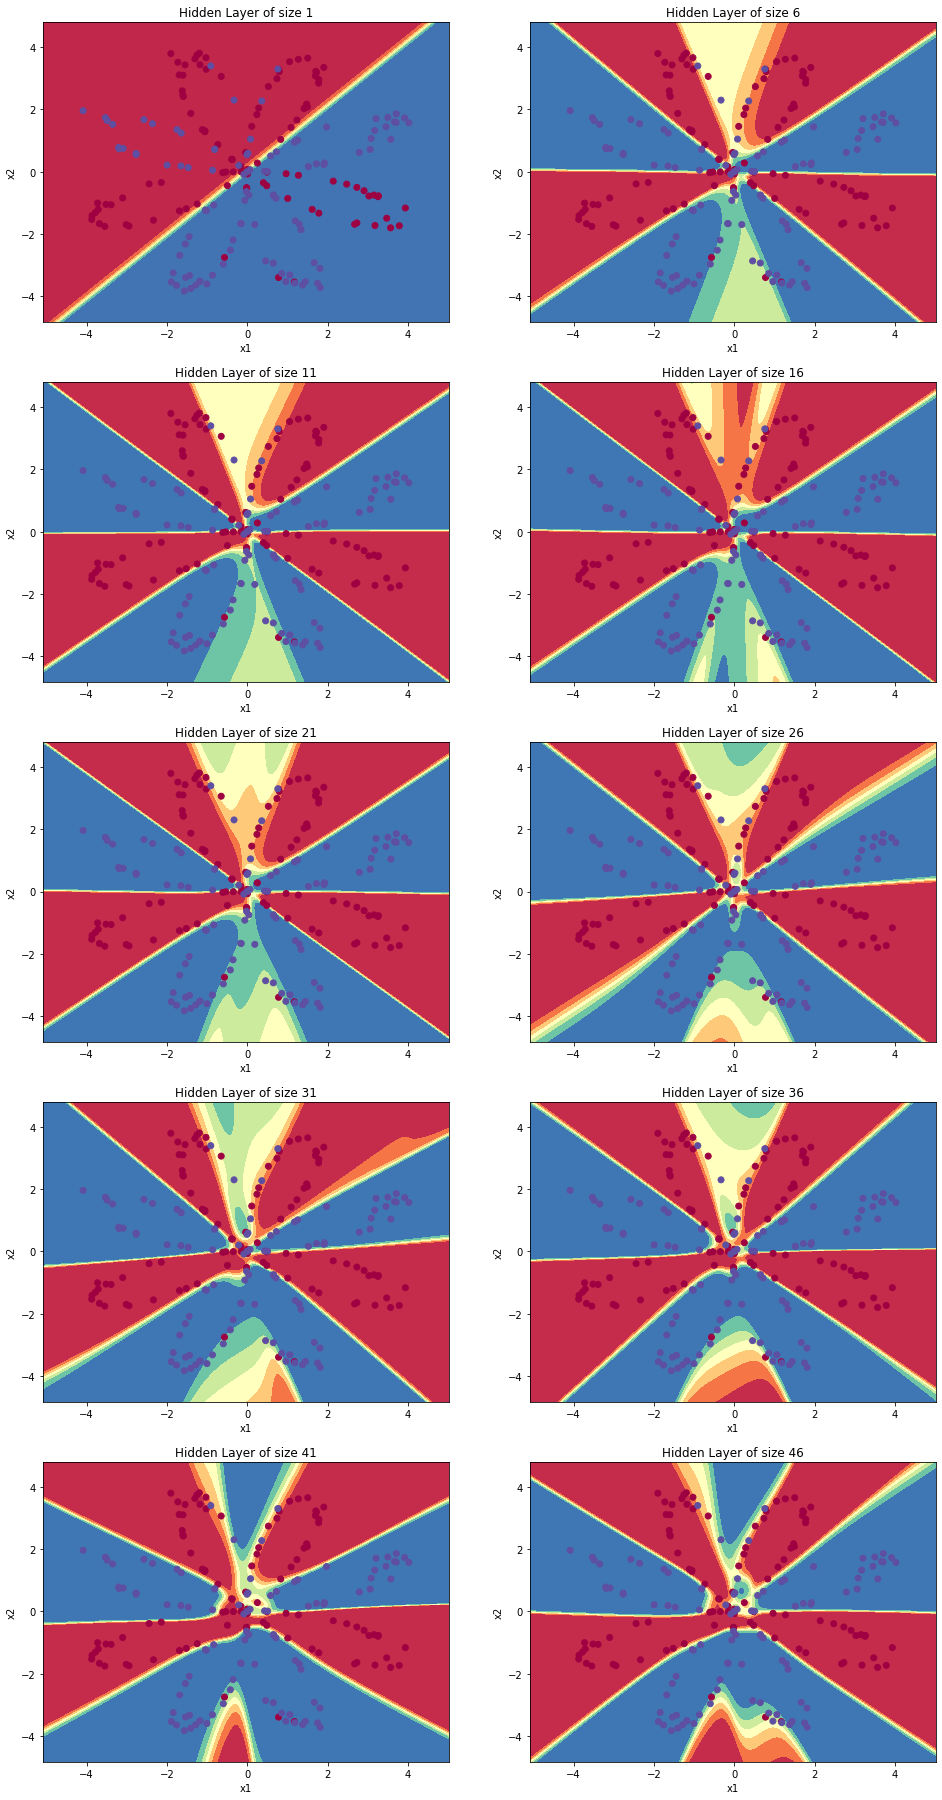

In [13]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = np.arange(1, 50, 5)
accuracy = []
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)

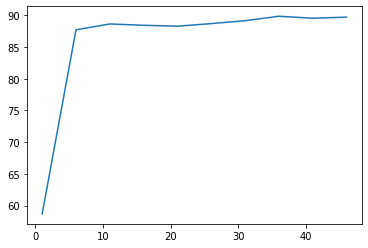

In [14]:
plt.plot(hidden_layer_sizes, accuracy)

# Dataset Circles

Pada Dataset ini, data dengan label merah umumnya di bagian pinggir, atau luar. Sedangkan data yang biru cenderung di bagian dalam. Seperti data sebelumnya, jumlah neuron sebanyak 6 buah sudah cukup untuk memodelkan dataset ini.

Cost after iteration 0: 0.314121
Cost after iteration 10000: 0.163170
Cost after iteration 20000: 0.160834
Cost after iteration 30000: 0.160072
Cost after iteration 40000: 0.159681
Cost after iteration 50000: 0.159360
Cost after iteration 60000: 0.159083
Cost after iteration 70000: 0.158841
Cost after iteration 80000: 0.158625
Cost after iteration 90000: 0.158428
train accuracy: 67.51985102937066 %


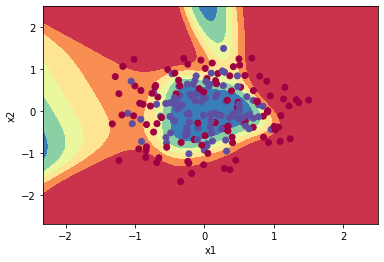

In [15]:
X, Y = loader.load_dataset("circles")
parameters = nn_model(X, Y, 8, 100000, 0.05, True)
get_accuracy(parameters, X, Y)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

Accuracy for 1 hidden units: 55.05373583465634 %
Accuracy for 6 hidden units: 67.41938579901716 %
Accuracy for 11 hidden units: 67.88244618795053 %
Accuracy for 16 hidden units: 69.98679663654426 %
Accuracy for 21 hidden units: 69.28281913894897 %
Accuracy for 26 hidden units: 76.96973656350718 %
Accuracy for 31 hidden units: 72.46327464520218 %
Accuracy for 36 hidden units: 74.27781369105406 %
Accuracy for 41 hidden units: 76.60497274879158 %
Accuracy for 46 hidden units: 75.68342831390913 %


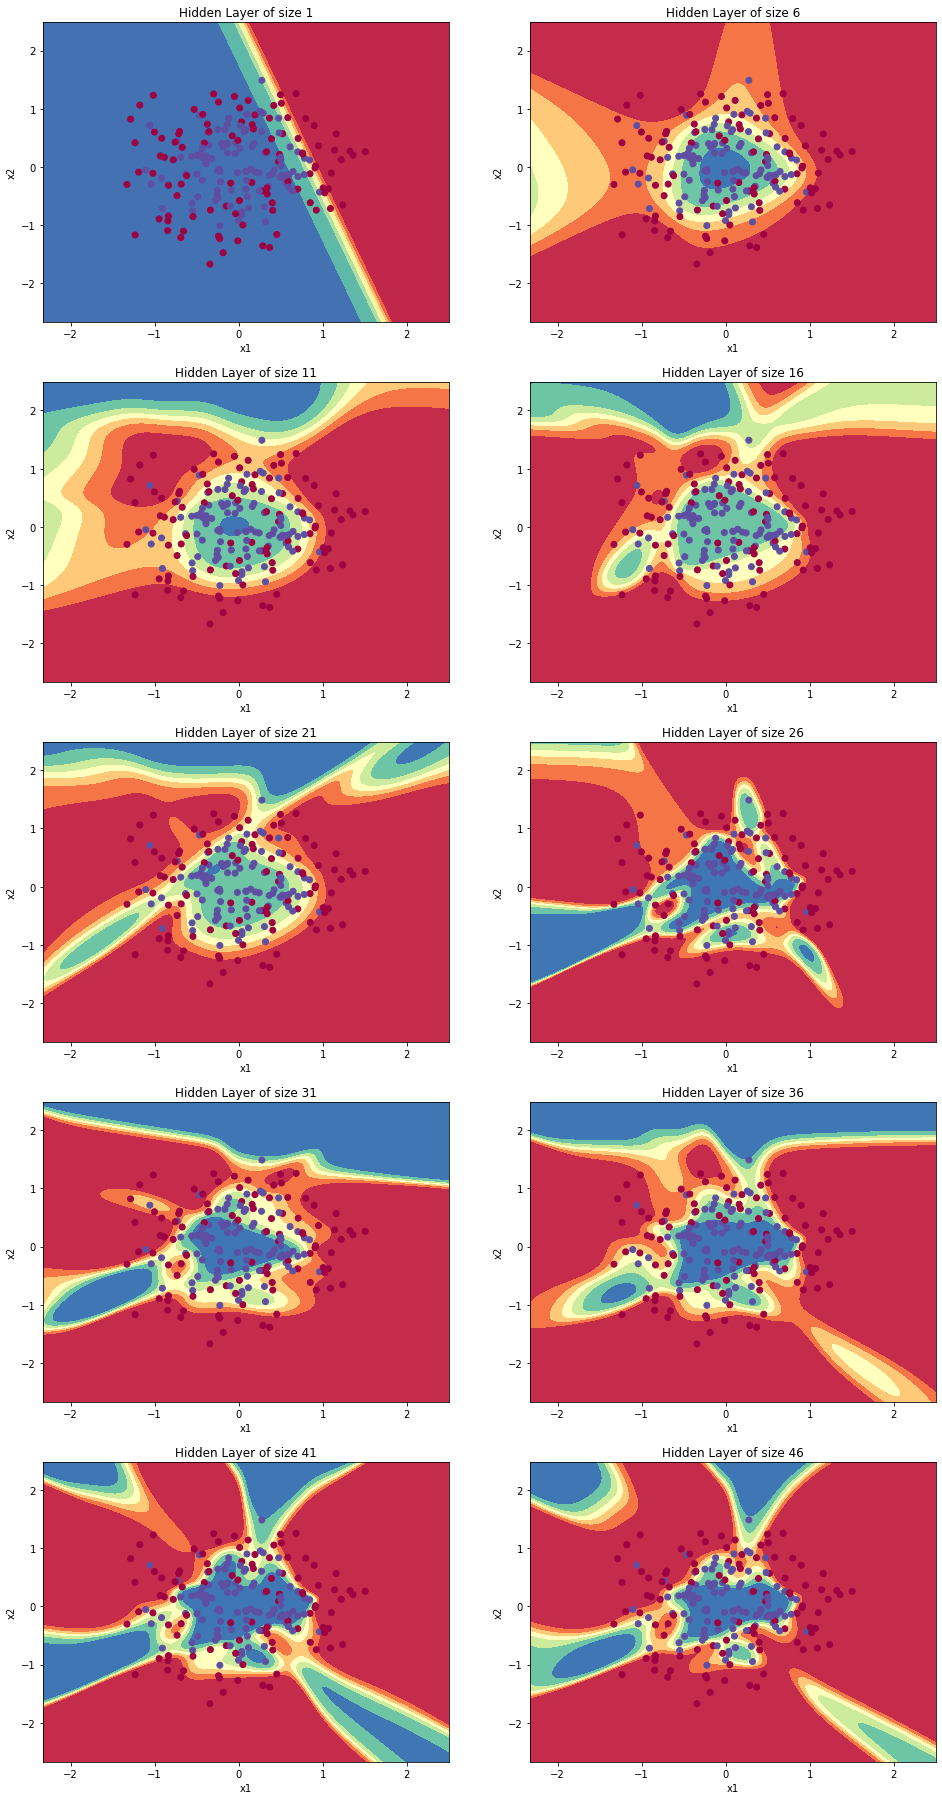

In [16]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = np.arange(1, 50, 5)
accuracy = []
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)

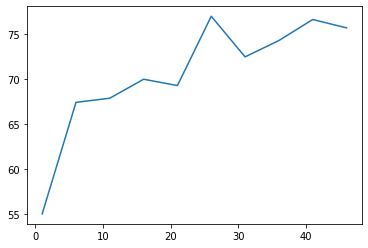

In [17]:
plt.plot(hidden_layer_sizes, accuracy)

# Dataset Moons

Dari grafik terlihat jelas bahwa dataset ini sudah cukup terpisah jika beda label dari awal, sehingga akurasi awal dari model ini sudah lebih baik daripada data-data sebelumnya, tetapi seperti data sebelumnya, 6 buah neuron menjadi titik optimalnya.

Cost after iteration 0: 0.277123
Cost after iteration 10000: 0.079887
Cost after iteration 20000: 0.021296
Cost after iteration 30000: 0.012141
Cost after iteration 40000: 0.009893
Cost after iteration 50000: 0.008794
Cost after iteration 60000: 0.008090
Cost after iteration 70000: 0.007592
Cost after iteration 80000: 0.007220
Cost after iteration 90000: 0.006933
train accuracy: 98.15857558428247 %


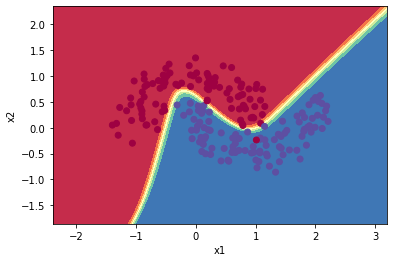

In [18]:
X, Y = loader.load_dataset("moons")
parameters = nn_model(X, Y, 8, 100000, 0.05, True)
get_accuracy(parameters, X, Y)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

Accuracy for 1 hidden units: 81.8413773933467 %
Accuracy for 6 hidden units: 98.88153660432255 %
Accuracy for 11 hidden units: 98.90492497066862 %
Accuracy for 16 hidden units: 98.91499800927927 %
Accuracy for 21 hidden units: 98.92977536723274 %
Accuracy for 26 hidden units: 98.92407931617196 %
Accuracy for 31 hidden units: 98.87212508884446 %
Accuracy for 36 hidden units: 98.99402989128563 %
Accuracy for 41 hidden units: 98.86255145387767 %
Accuracy for 46 hidden units: 98.9808914618836 %


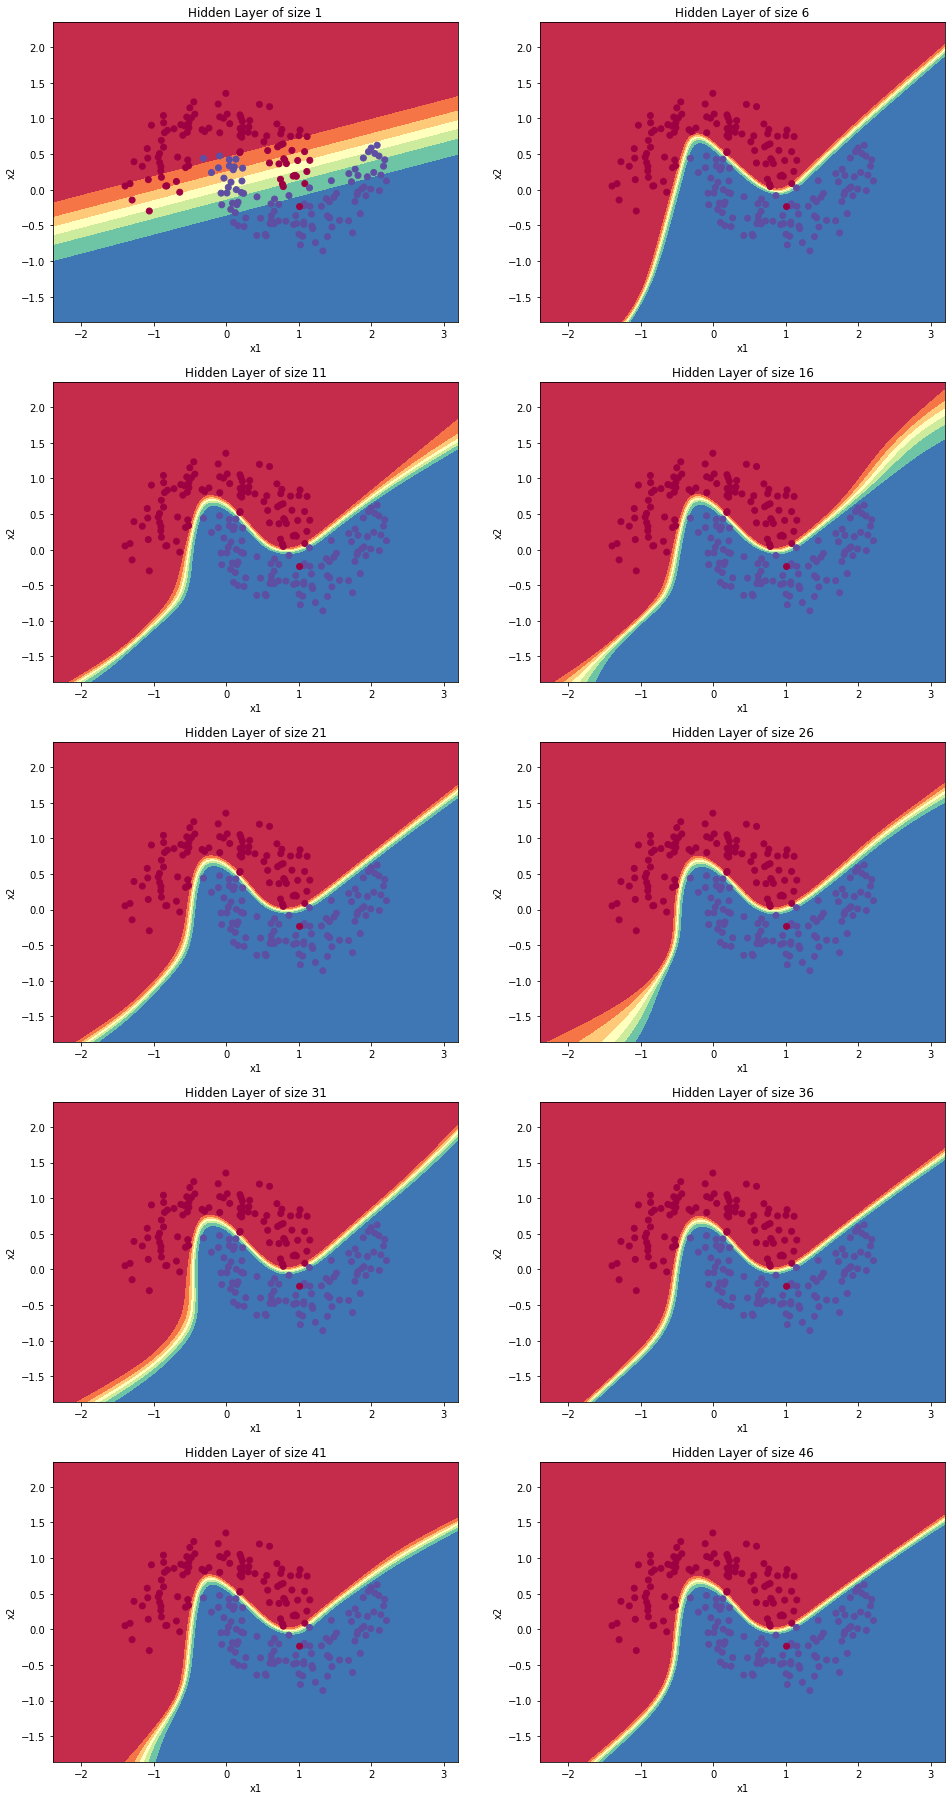

In [19]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = np.arange(1, 50, 5)
accuracy = []
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)

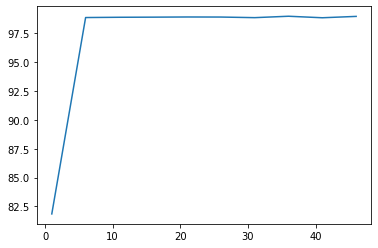

In [20]:
plt.plot(hidden_layer_sizes, accuracy)

# Dataset Blobs

Dataset Blobs memiliki karakteristik seperti data yang memilki label yang sama tercluster di beberapa tempat, hal ini menyebabkan hanya enam neuron tidak cukup untuk mendapatkan akurasi yang paling baik, dapat dilihat bahwa akurasi maksimal diperoleh pada 26 neuron, dan nilai tidak berubah jauh setelah itu. Tetapi pada jumlah neuron 46, terjadi penurunan akurasi yang drastis, ini disebabkan oleh terjadinya *overfitting*.

Cost after iteration 0: 0.266804
Cost after iteration 10000: 0.083488
Cost after iteration 20000: 0.079330
Cost after iteration 30000: 0.077863
Cost after iteration 40000: 0.077269
Cost after iteration 50000: 0.076919
Cost after iteration 60000: 0.076672
Cost after iteration 70000: 0.076478
Cost after iteration 80000: 0.076310
Cost after iteration 90000: 0.076154
train accuracy: 84.02022121241055 %


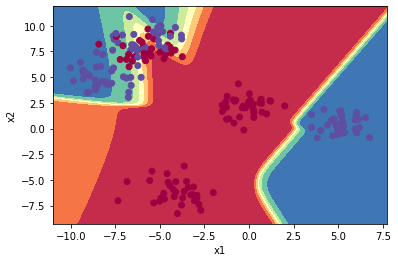

In [21]:
X, Y = loader.load_dataset("blobs")
parameters = nn_model(X, Y, 8, 100000, 0.05, True)
get_accuracy(parameters, X, Y)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

Accuracy for 1 hidden units: 59.72404731897497 %
Accuracy for 6 hidden units: 82.25025211645996 %
Accuracy for 11 hidden units: 83.50556399380898 %
Accuracy for 16 hidden units: 87.21794578232735 %
Accuracy for 21 hidden units: 83.53812387408402 %
Accuracy for 26 hidden units: 85.93872358460817 %
Accuracy for 31 hidden units: 88.36068238721981 %
Accuracy for 36 hidden units: 88.04172407531112 %
Accuracy for 41 hidden units: 88.43105841358076 %
Accuracy for 46 hidden units: 89.01167393876868 %


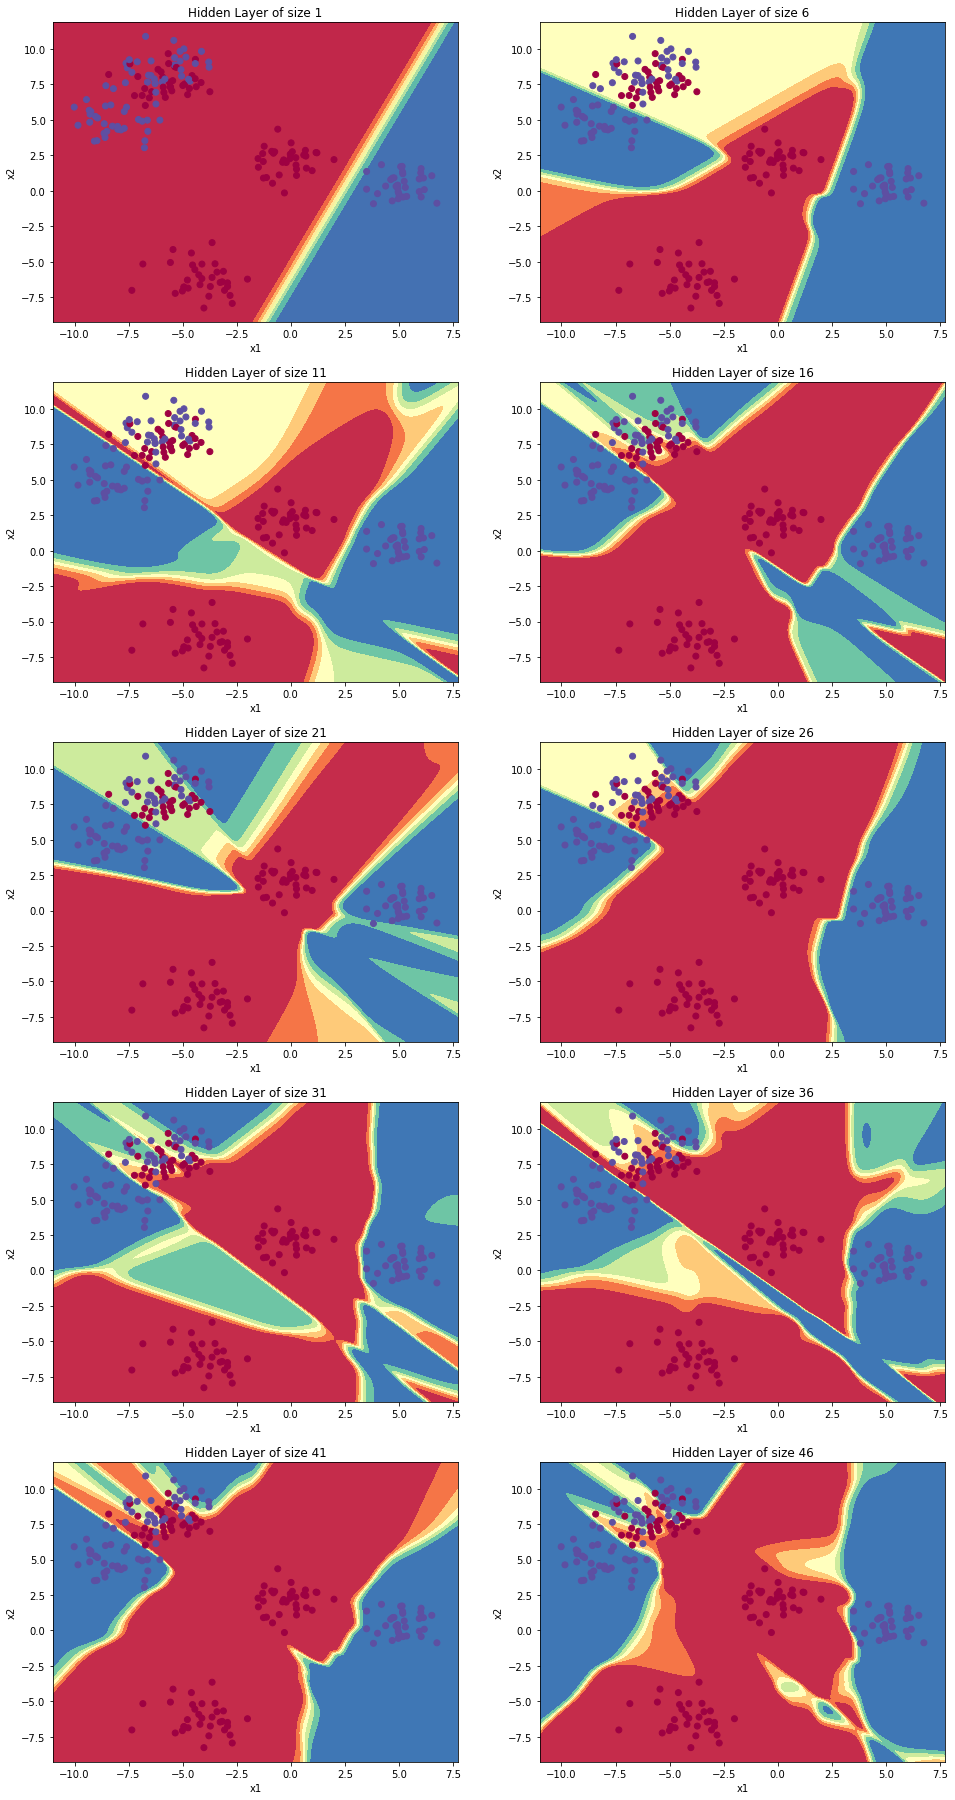

In [22]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = np.arange(1, 50, 5)
accuracy = []
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)

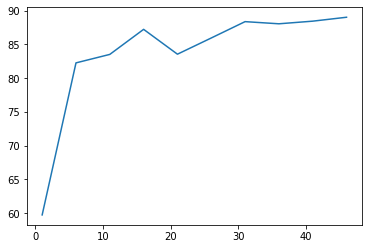

In [23]:
plt.plot(hidden_layer_sizes, accuracy)

# Dataset Quantiles

Perhatikan bahwa dataset ini bila kita lihat plotnya secara kasat mata, cukup teratur, dengan satu jenis label di tengah, dan label lainnya di sekitarnya. Sehingga seperti pada dataset Moons, akurasi yang sangat baik diperoleh mulai dari 6 neuron, dan tidak berubah jauh jika neuron ditambahkan lebih dari itu.

Cost after iteration 0: 0.294916
Cost after iteration 10000: 0.039924
Cost after iteration 20000: 0.026397
Cost after iteration 30000: 0.020741
Cost after iteration 40000: 0.017588
Cost after iteration 50000: 0.015356
Cost after iteration 60000: 0.013706
Cost after iteration 70000: 0.012453
Cost after iteration 80000: 0.011442
Cost after iteration 90000: 0.010582
train accuracy: 95.70611441508882 %


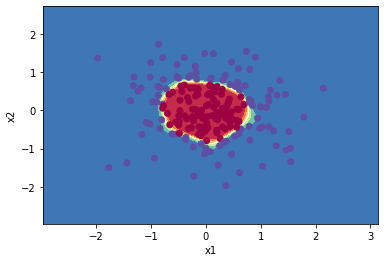

In [24]:
X, Y = loader.load_dataset("quantiles")
parameters = nn_model(X, Y, 8, 100000, 0.05, True)
get_accuracy(parameters, X, Y)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

In [ ]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = np.arange(1, 50, 5)
accuracy = []
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)

In [ ]:
plt.plot(hidden_layer_sizes, accuracy)

# Dataset Random

Dataset Random memiliki akurasi yang cukup buruk, ini dikarenakan setiap titik dengan label berbeda jaraknya dekat dan bertumpuk satu sama lain, sehingga sulit sekali mengklasifikasikan daerah berdasarkan label ini. Dapat dilihat bahwa untuk jumlah neuron berapapun, akurasi yang diperoleh tidak lebih dari 55%.

In [ ]:
X, Y = loader.load_dataset("random")
parameters = nn_model(X, Y, 8, 100000, 0.05, True)
get_accuracy(parameters, X, Y)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

In [ ]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = np.arange(1, 50, 5)
accuracy = []
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)

In [ ]:
plt.plot(hidden_layer_sizes, accuracy)

# Kesimpulan

Untuk dataset yang sudah sangat teratur, seperti Flower, Moons, Quantiles, dan Circles, mudah sekali untuk mengklasifikasinya, 6 buah neuron sudah sangat cukup, dan lebih dari itu tidak akan memberikan akurasi yang jauh lebih baik, bahkan bisa saja berkurang.

Untuk dataset yang sedikit lebih acak dan lebih banyak noise seperti Blobs, akurasi yang paling baik diperoleh ketika jumlah neuron lebih dari 20. Tetapi akurasi menurun drastis akibat *overfitting* di jumlah neuron yang terlalu banyak.

Sedangkan untuk dataset Random, sangat wajar bila akurasi yang didapat sangat buruk, berapapun jumlah neuron yang dipakai. Seperti namanya, data random tidak memiliki pola dan data-data label yang berbeda bertumpuk dan berdekatan, sehingga tidak mungkin mencari model yang cocok untuk data yang tidak memiliki pola.